![image](https://www.shell.com/energy-and-innovation/the-energy-future/scenarios/shell-scenario-sky/_jcr_content/pageCarouselImage.img.960.jpeg/1521983923121/future-of-energy-homepage-r.jpeg?imwidth=960)


> About the Host
# 🔌ASHRAE -Start Here: A GENTLE Introduction

- <a href='#1'>1. Introduction: ASHRAE - Great Energy Predictor III</a>
    - <a href='#1-1'>1.1. Data Description</a>
    - <a href='#1-2'>1.2. Evaluation Metric</a>
- <a href='#2'>2. Imports</a>
- <a href='#3'>3. Read in Data</a>
- <a href='#4'>4. Glimpse of Data</a>
- <a href='#5'>5. Reducing Memory Size</a>
- <a href='#6'>6. Exploratory Data Analysis</a>
    - <a href='#6-1'>6.1. Examine the Distribution of the Target Column</a>
    - <a href='#6-2'>6.2. Missing data and zeros visualized</a>
    - <a href='#6-3'>6.3. Examine Missing Values</a>
    - <a href='#6-4'>6.4. Column Types</a>
    - <a href='#6-5'>6.5. Correlations</a>
- <a href='#7'>7. Ploting</a>
- <a href='#8'>8. Simple Single Series Analysis</a>
- <a href='#9'>9. Outlier Distribution</a>
    - <a href='#9-1'>9.1. Group data in a daily basis</a>
    - <a id='9-2'>9.2. Aggregate the data for buildings</a>
    - <a href='#9-3'>9.3. Identifying outliers</a>
- <a href='#10'>10. Simple Feature Engineering and Modeling</a>
    - <a href='#10-1'>10.1. Building DF merge through concat</a>
    - <a href='#10-2'>10.2. Weather DF merge over concat</a>
- <a href='#11'>11. ASHRAE - Data minification</a>
- <a href='#12'>12. Some Features</a>
- <a href='#13'>13. Encoding Variables</a>
- <a href='#14'>14. Handling missing values</a>
- <a href='#15'>15. ASHRAE Ligthgbm Simple Fe </a>
- <a href='#16'>ASHRAE Energy prediction - small summary</a>
- <a href='#17'>17. Final</a>




    

# <a id='1'>1. Introduction: ASHRAE - Great Energy Predictor III</a>

In [134]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


## <a id='1-1'>1.1 Data</a>



## <a id='1-1'>1.2 Evaluation Metric</a>

# <a id='2'>2. Imports </a>

In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle    

# <a id='3'>3. Read in Data </a>

<a href='#1'>Top</a>

<p><font size="3" color="green" style="Comic Sans MS;">

First, we can list all the available data files. There are a total of 6 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 4 other files containing additional information about energy types based on historic usage rates and observed weather.
</font></p>

In [137]:
print(os.listdir("./ashrae-energy-prediction/"))

['weather_test.csv', 'weather_train.csv', 'test.csv', 'train.csv', 'building_metadata.csv', 'sample_submission.csv']


In [138]:
%%time
root = './ashrae-energy-prediction/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 25.8 s, sys: 5.09 s, total: 30.9 s
Wall time: 27.2 s


# <a id='4'>4. Glimpse of Data</a>

<a href='#1'>Top</a>

In [139]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


# <a id='5'>5. Reducing Memory Size</a>

<a href='#1'>Top</a>


<p><font size="3" color="green" style="Comic Sans MS;">
It is necessary that after using this code, carefully check the output results for each column.
</font></p>

In [140]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


<p><font size="3" color="green" style="Comic Sans MS;">
Reducing memory
</font></p>

In [141]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)




<html>
<body>
<p><font size="5" color="Red">🔓MEMORY USAGE AFTER COMPLETION:</font></p>
<p>Mem. usage decreased to  : <b> 289.19 Mb (53.1% reduction)</b></p>
<p>Mem. usage decreased to  : <b>  6.08 Mb (68.1% reduction)</b></p>
<p>Mem. usage decreased to  : <b> 0.03 Mb (60.3% reduction)</b></p>

</body>
</html>





> #### train_df data

In [142]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [143]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

> #### weather_train_df data

In [144]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [145]:
weather_train_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

> #### weather_test_df data

In [146]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [147]:
weather_test_df.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

> #### building_meta_df data

In [148]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [149]:
building_meta_df.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

# <a id='6'>6. Exploratory Data Analysis</a>

<a href='#1'>Top</a>


<p><font size="3" color="green" style="Comic Sans MS;">
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. 
</font></p>

## <a id='6-1'>6.1 Examine the Distribution of the Target Column</a>


<p><font size="3" color="green" style="Comic Sans MS;">
The target is meter_reading - Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.</font></p>


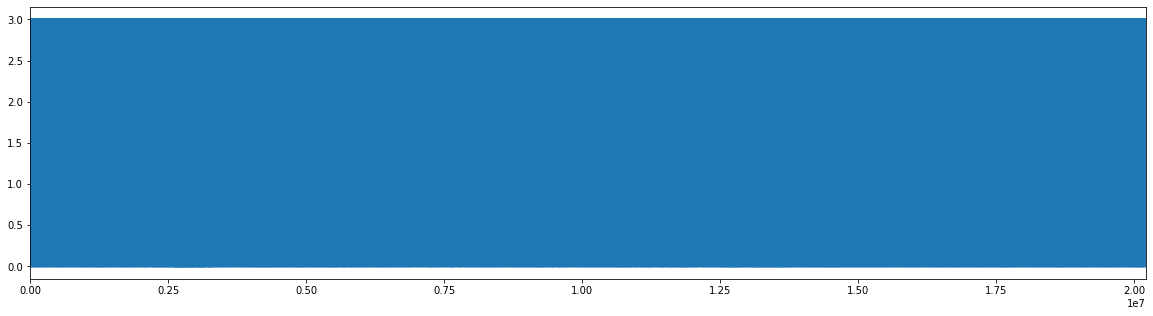

In [150]:
for key, d in train_df.groupby('meter_reading'):
    break
    d.head()
plt.figure(figsize = (20,5))
d['meter'].plot()

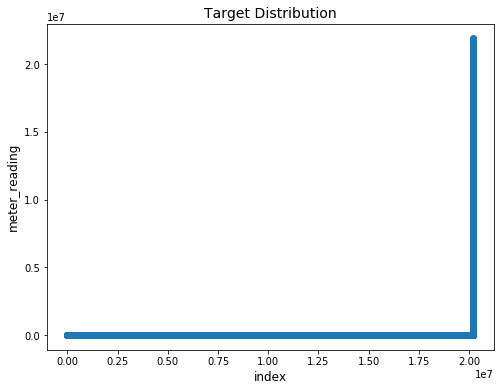

In [151]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['meter_reading'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('meter_reading', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

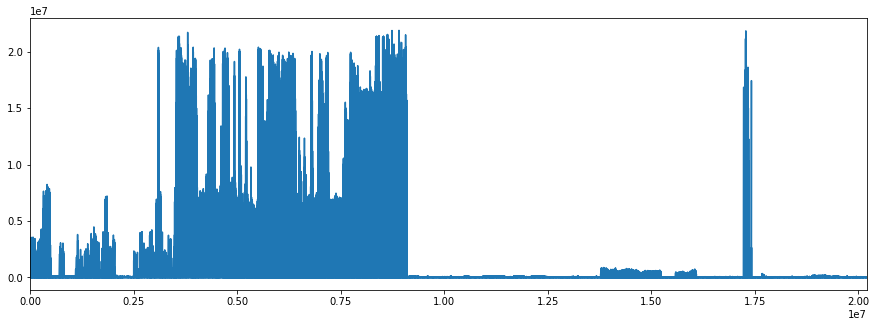

In [152]:
plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

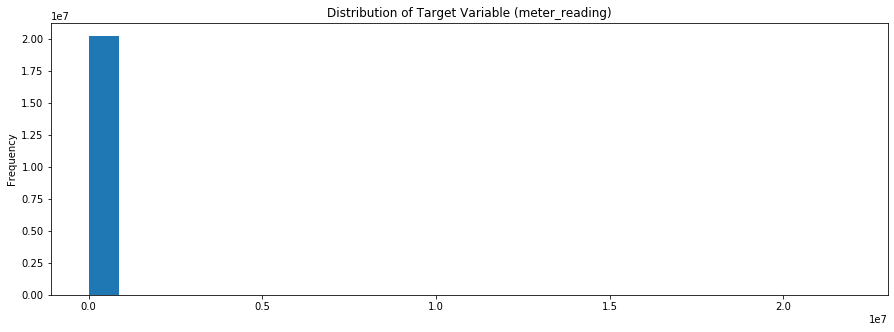

In [153]:
train_df['meter_reading'].plot(kind='hist',
                            bins=25,
                            figsize=(15, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

## <a id='6-2'>6.2 Missing data and zeros visualized</a>


look that by ganfear:[ Missing data and zeros visualized](https://www.kaggle.com/ganfear/missing-data-and-zeros-visualized)




<p><font size="3" color="green" style="Comic Sans MS;">
Goal: for each building and meter pair, visualize where target is missing and where target is zero VS time.


</font></p>


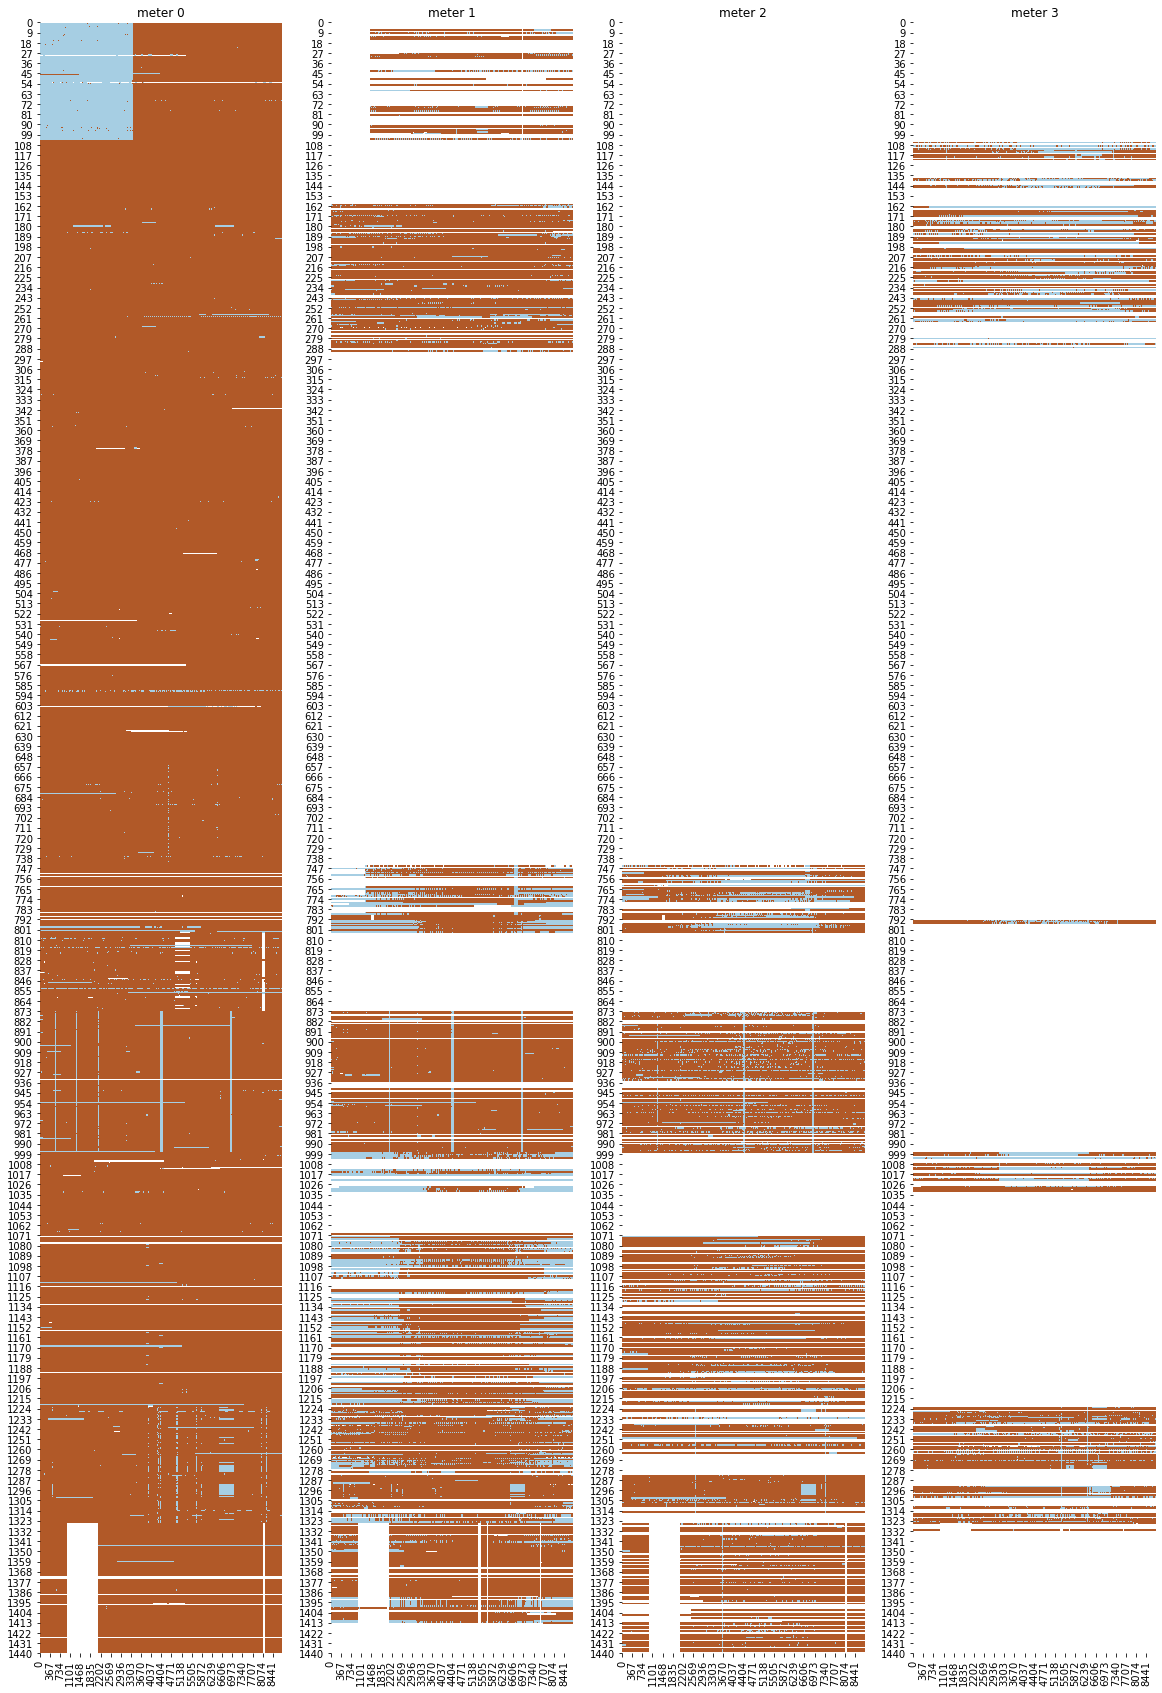

In [154]:
# Load data
train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train[train.meter==meter].copy().reset_index()
    # 1970/1/1からの時間(h)
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    # 2016/1/1からの時間(h)
    df.timestamp -= df.timestamp.min()
    # (building_id × timestamp)
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values: #　各行について
        if l[2]!=meter:continue # 全部同じmeterでは...?
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1 # meterの値を0-1で埋める
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

- Vertical blue lines may be suspicious

Legend:
* X axis: hours elapsed since Jan 1st 2016, for each of the 4 meter types
* Y axis: building_id
* Brown: meter reading available with non-zero value
* Light blue: meter reading available with zero value
* White: missing meter reading

## <a id='6-3'>6.3 Examine Missing Values</a>


<p><font size="3" color="green" style="Comic Sans MS;">
Next we can look at the number and percentage of missing values in each column. 

</font></p>



### checking missing data for train_df

In [155]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(4)

,Total,Percent
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


### checking missing data for weather_train_df

In [156]:
# checking missing data
total = weather_train_df.isnull().sum().sort_values(ascending = False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data.head(9)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


### checking missing data for weather_test_df

In [157]:
# checking missing data
total = weather_test_df.isnull().sum().sort_values(ascending = False)
percent = (weather_test_df.isnull().sum()/weather_test_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_test_data.head(9)

,Total,Percent
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


### checking missing data for building_meta_df

In [158]:
# checking missing data
total = building_meta_df.isnull().sum().sort_values(ascending = False)
percent = (building_meta_df.isnull().sum()/building_meta_df.isnull().count()*100).sort_values(ascending = False)
missing_building_meta_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


## <a id='6-4'>6.4 Column Types</a>


Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [159]:
# Number of each type of column
train_df.dtypes.value_counts()

float32           1
datetime64[ns]    1
int16             1
int8              1
dtype: int64

In [160]:
# Number of unique classes in each object column
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

## <a id='6-5'>6.5 Correlations</a>

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “**very weak**”
*  .20-.39 “**weak**”
*  .40-.59 “**moderate**”
*  .60-.79 “**strong**”
* .80-1.0 “**very strong**”


In [161]:
# Find correlations with the target and sort
correlations = train_df.corr()['meter_reading'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64


In [162]:
corrs = train_df.corr()
corrs

,building_id,meter,meter_reading
building_id,1.000000,0.222268,0.008761
meter,0.222268,1.000000,0.017672
meter_reading,0.008761,0.017672,1.000000


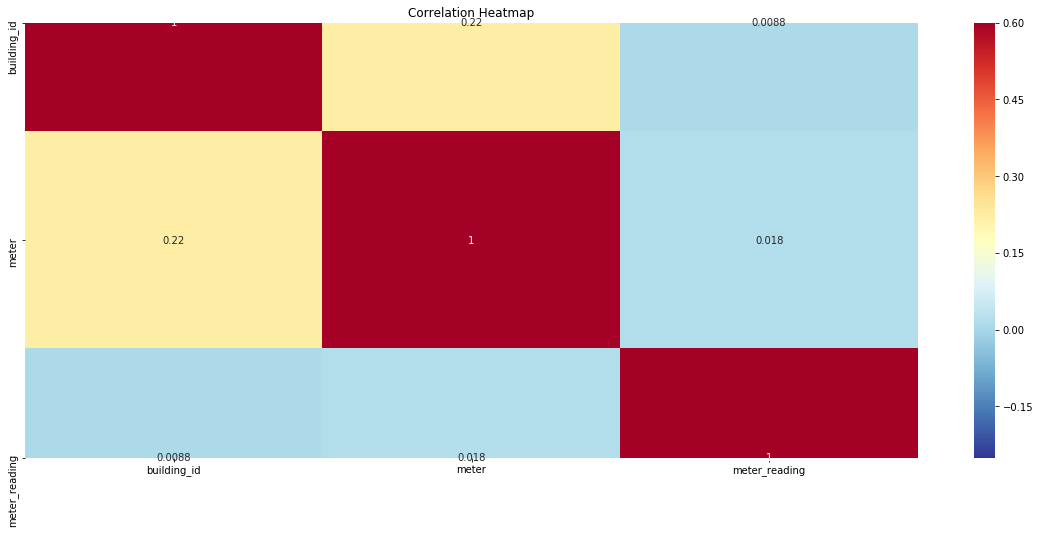

In [163]:
plt.figure(figsize = (20, 8))

# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

# <a id='7'>7. Ploting</a>

<a href='#1'>Top</a>

In [164]:
train_df.building_id.nunique()

1449

- Let's check the distribution of target value in train dataset

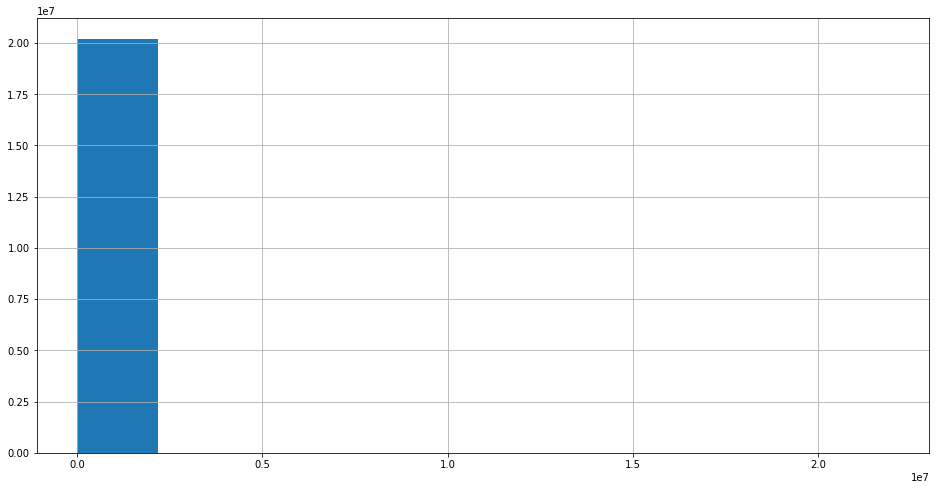

In [165]:
train_df['meter_reading'].hist(figsize=(16, 8))

In [166]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test_df[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

> plot dist. curves for train and test weather data for air_temperature

### 温度の分布: 大体一致、正規分布に近い

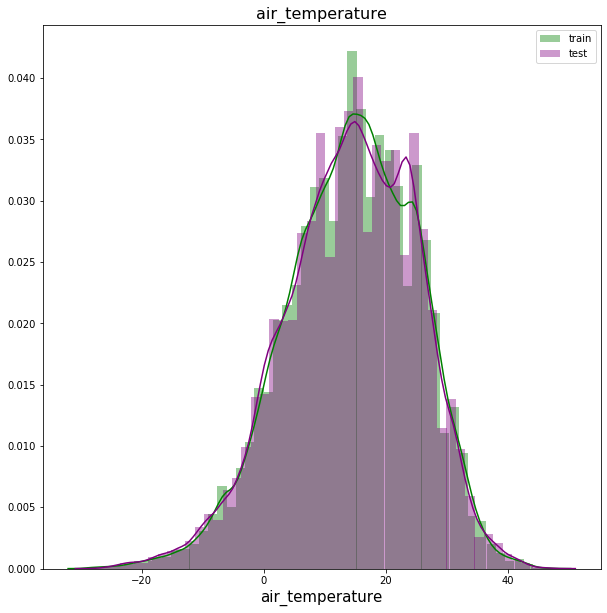

In [167]:
plot_dist_col('air_temperature')

> plot dist. curves for train and test weather data for cloud_coverage

### 雲の割合 (okras) の分布: 欠損多いがだいたい一致

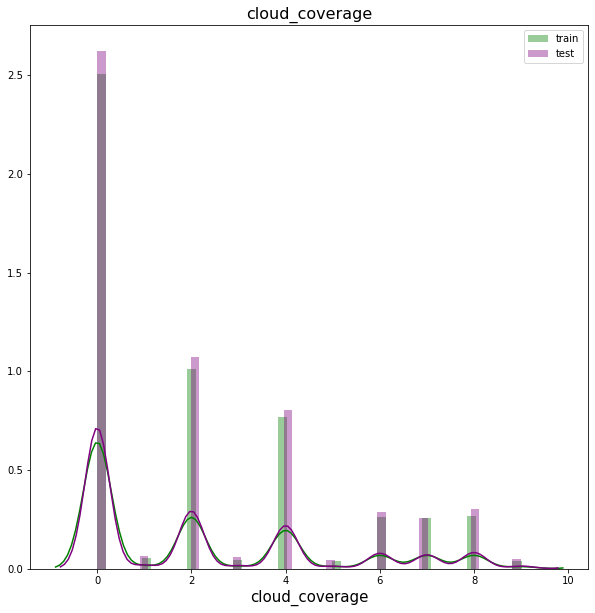

In [168]:
plot_dist_col('cloud_coverage')

> plot dist. curves for train and test weather data for dew_temperature

### 露点温度 (≒湿度) の分布: 大体一致（としていい？）

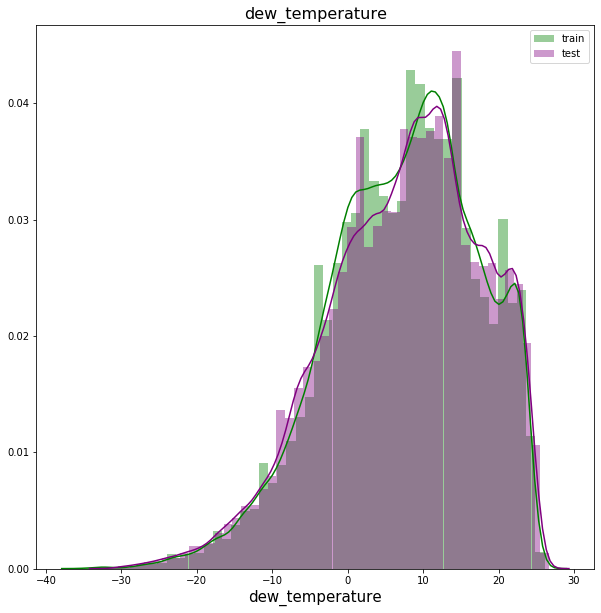

In [169]:
plot_dist_col('dew_temperature')

> plot dist. curves for train and test weather data for precip_depth_1_hr

### 1時間の降水量の分布: ほとんど0に固まってるし、要らなそう？

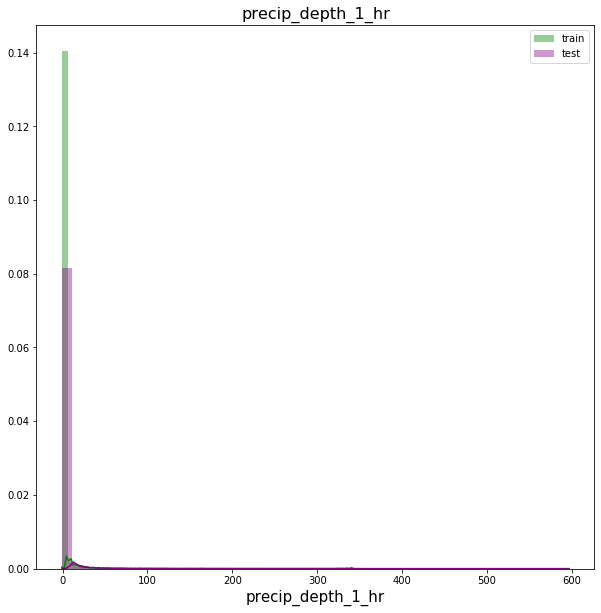

In [170]:
plot_dist_col('precip_depth_1_hr')

> plot dist. curves for train and test weather data for sea_level_pressure

### 海面気圧の分布: ほぼ一致、正規分布

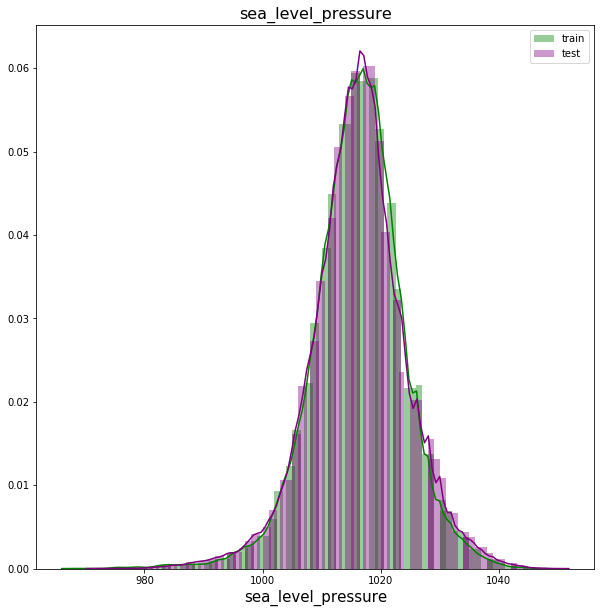

In [171]:
plot_dist_col('sea_level_pressure')

> plot dist. curves for train and test weather data for wind_direction

### 風の方向 (0-360) の分布: 大体一致

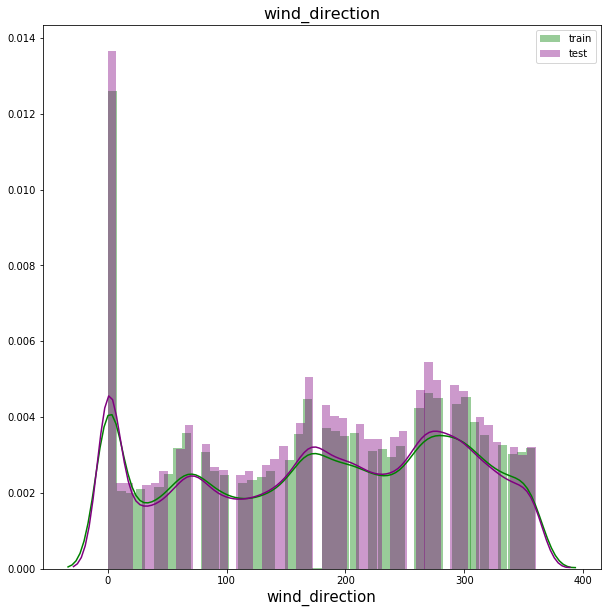

In [172]:
plot_dist_col('wind_direction')

> plot dist. curves for train and test weather data for wind_speed

### 風の速さの分布: 分布の上下動激しい

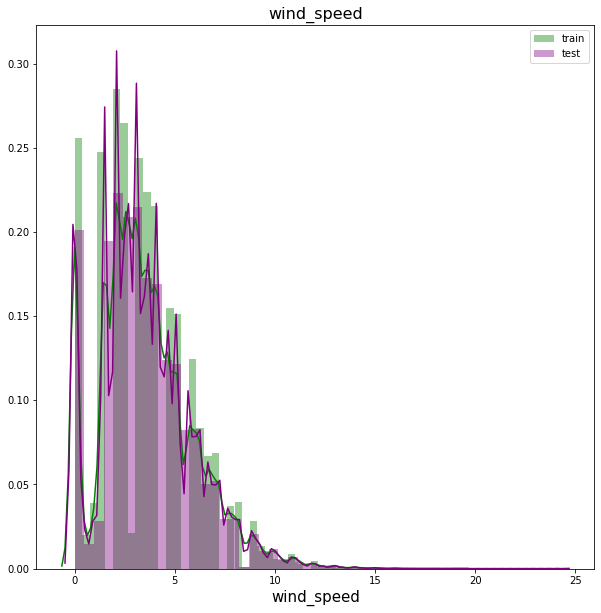

In [173]:
plot_dist_col('wind_speed')

# <a id='8'>8. Simple Single Series Analysis</a>


<a href='#1'>Top</a>

In [174]:
from statsmodels.tsa.seasonal import seasonal_decompose

## 全てのmeter

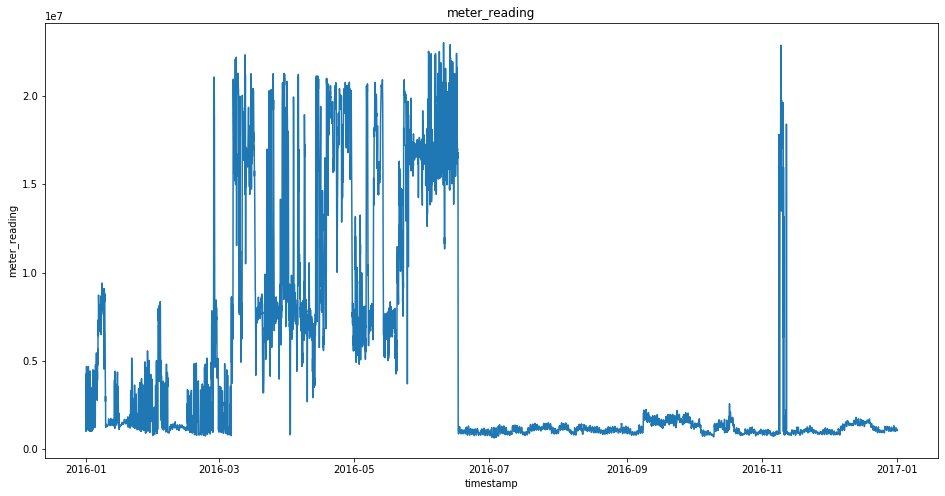

In [175]:
# ある時間の全ての建物、全てのmeterのmeter_readingの和
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

### 12時間おき

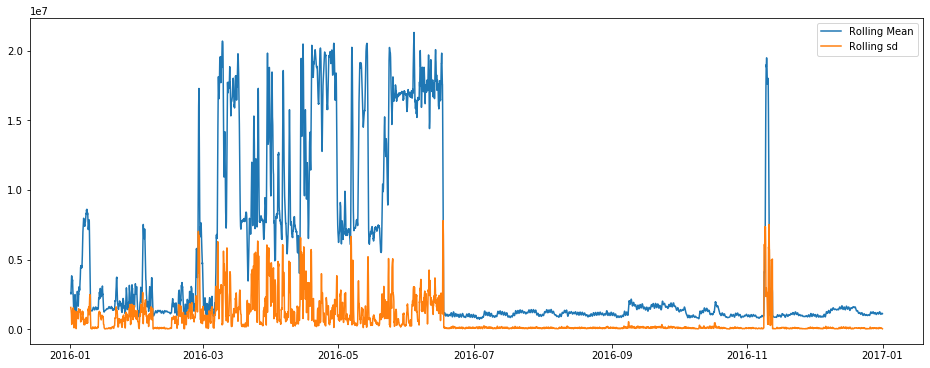

In [176]:
plt.figure(figsize=(16,6))
# 11時間前から現在まで（12時間分）のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

### トレンド、季節、残差に分解
### → 3 ~ 6月に多い？夏・冬に電気が上がるわけではないのか？

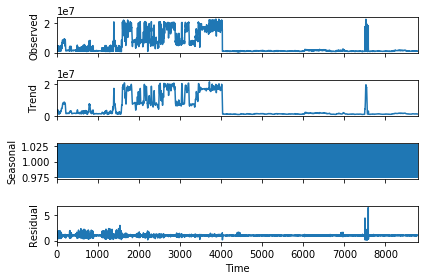

In [177]:
import statsmodels.api as sm
# multiplicative
# 12時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

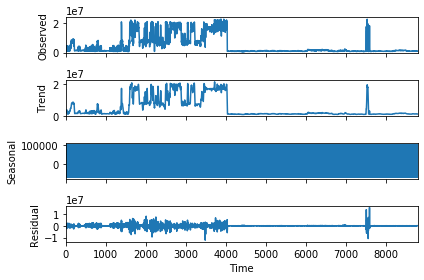

In [178]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

### 1日おきに見ると

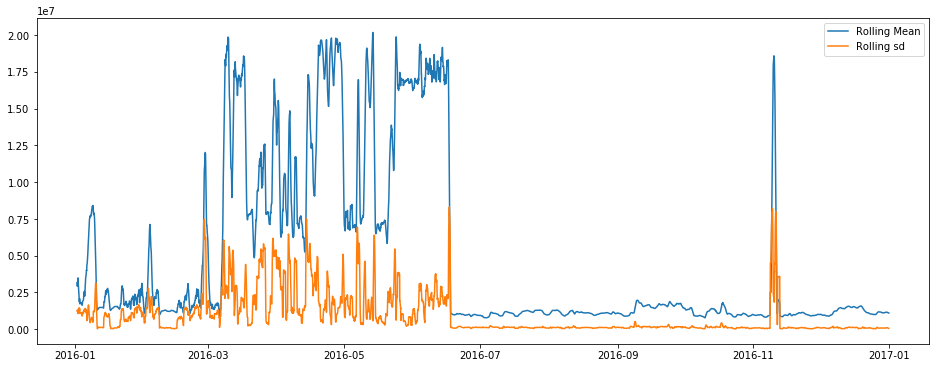

In [179]:
plt.figure(figsize=(16,6))
# 24時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=24,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=24,center=False).std(),label='Rolling sd');
plt.legend();

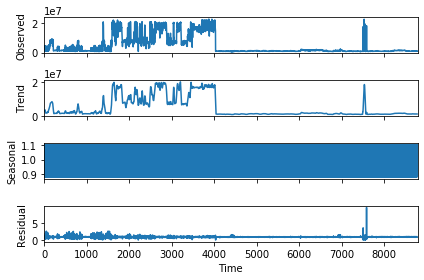

In [180]:
# multiplicative
# 24時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=24,model="multiplicative")
fig = res.plot()

### 5日おきに見ると

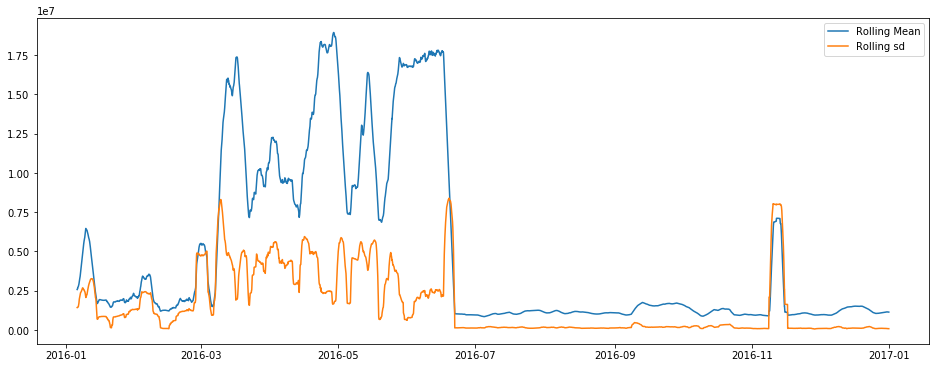

In [181]:
plt.figure(figsize=(16,6))
# 120時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=120,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=120,center=False).std(),label='Rolling sd');
plt.legend();

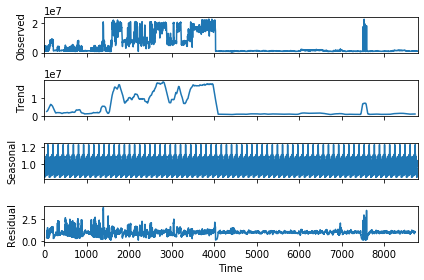

In [182]:
# multiplicative
# 120時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=120,model="multiplicative")
fig = res.plot()

## 電気

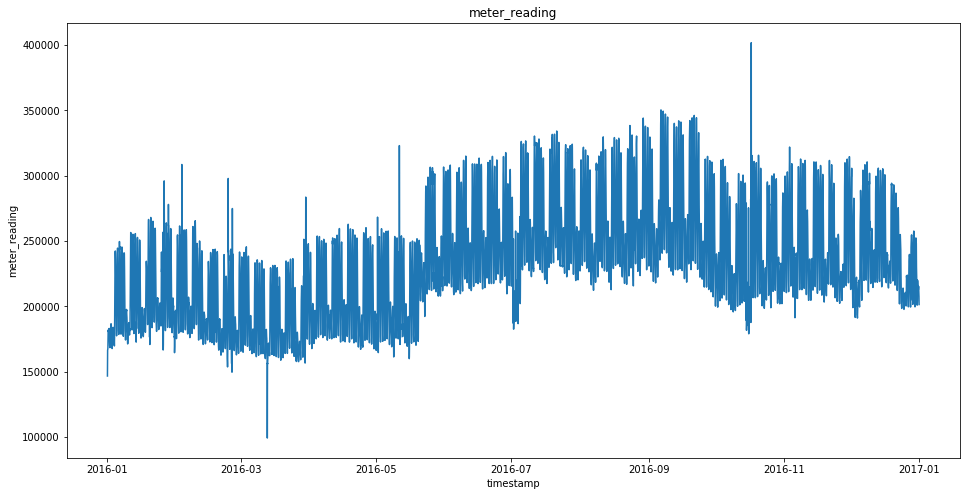

In [183]:
# ある時間の全ての建物、電気のmeter_readingの和
ts=train_df[train_df['meter']==0].groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

### 12時間おき

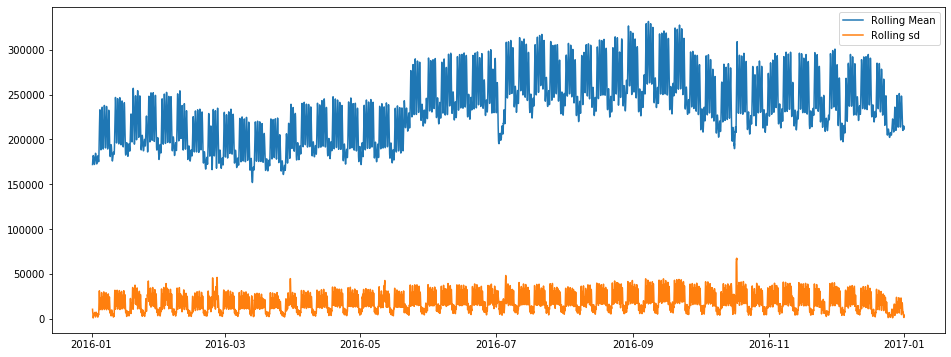

In [184]:
plt.figure(figsize=(16,6))
# 12時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

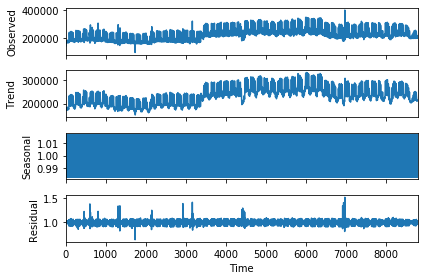

In [185]:
# multiplicative
# 12時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

### 1日おき→休日に電気の消費量減る

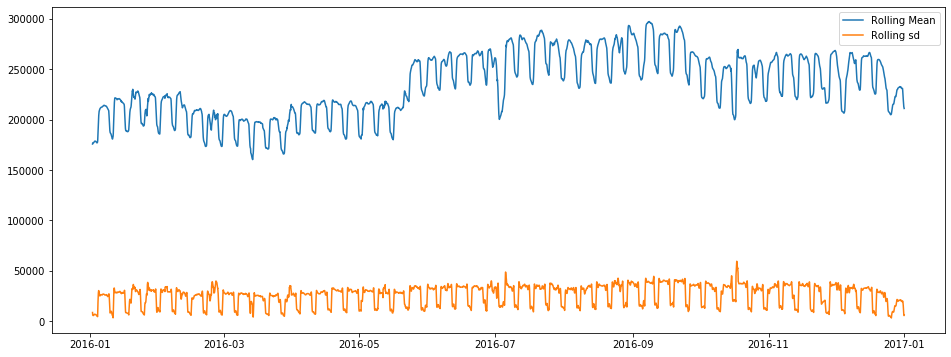

In [186]:
plt.figure(figsize=(16,6))
# 24時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=24,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=24,center=False).std(),label='Rolling sd');
plt.legend();

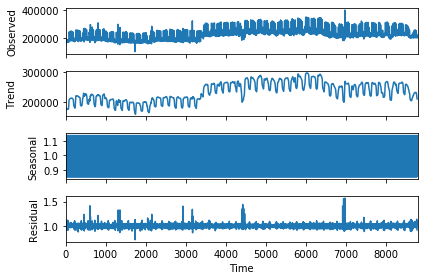

In [187]:
# multiplicative
# 24時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=24,model="multiplicative")
fig = res.plot()

### 7日おき

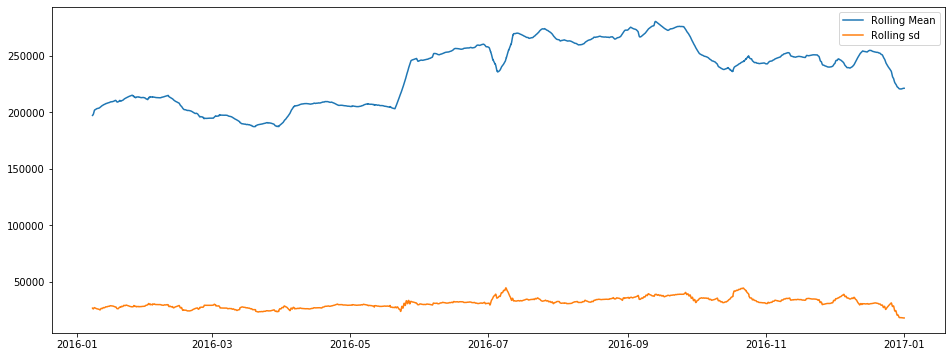

In [188]:
plt.figure(figsize=(16,6))
# 168時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=168,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=168,center=False).std(),label='Rolling sd');
plt.legend();

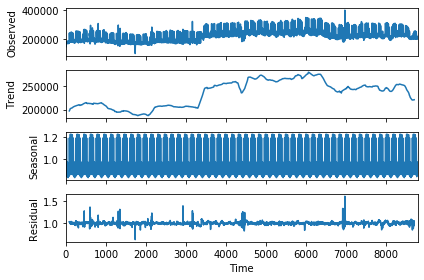

In [189]:
# multiplicative
# 168時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=168,model="multiplicative")
fig = res.plot()

## 冷水

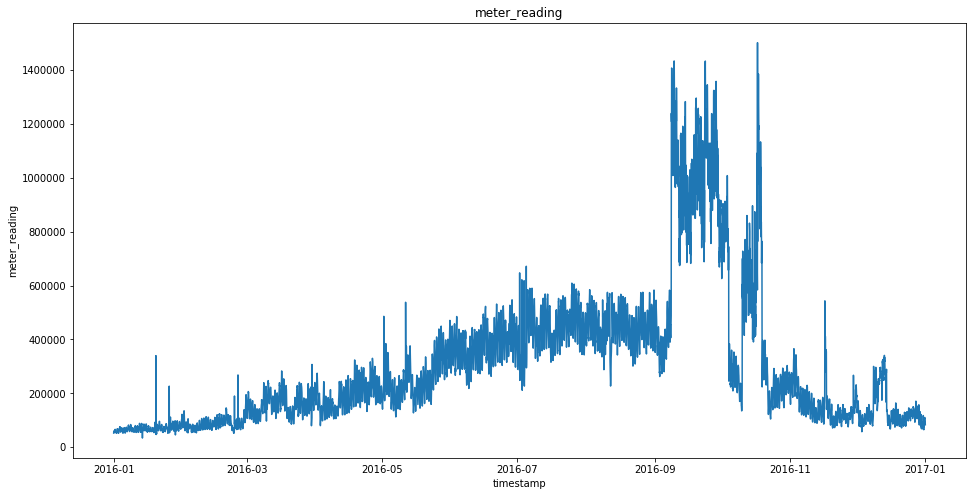

In [190]:
# ある時間の全ての建物、冷水のmeter_readingの和
ts=train_df[train_df['meter']==1].groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

### 12時間おき

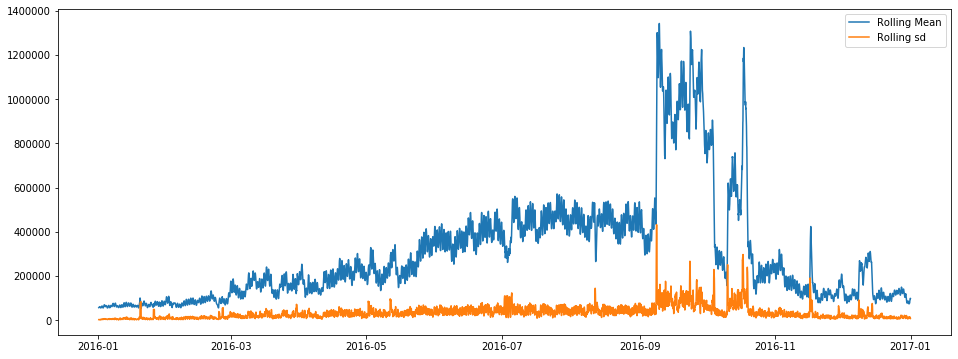

In [191]:
plt.figure(figsize=(16,6))
# 12時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

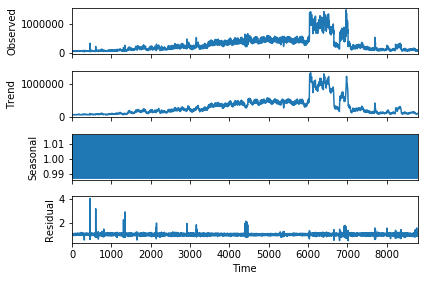

In [192]:
# multiplicative
# 12時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

### 1日おき

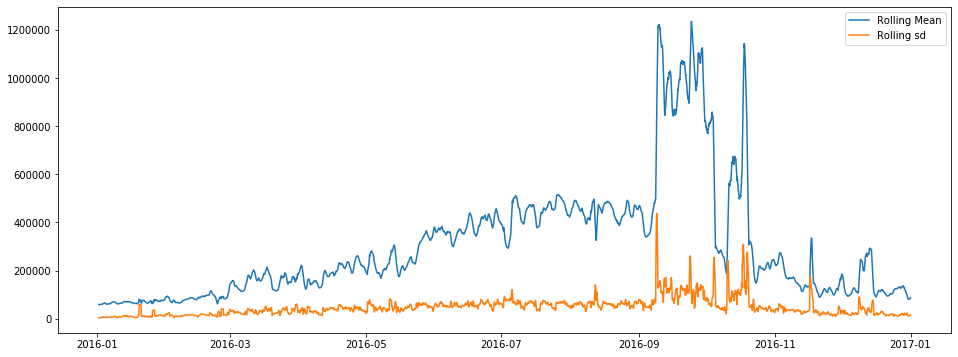

In [193]:
plt.figure(figsize=(16,6))
# 24時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=24,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=24,center=False).std(),label='Rolling sd');
plt.legend();

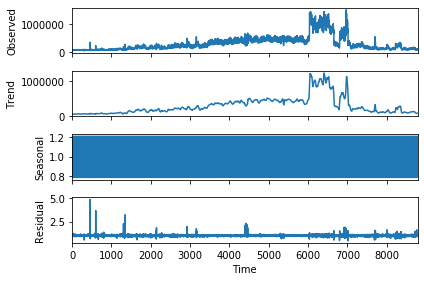

In [194]:
# multiplicative
# 24時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=24,model="multiplicative")
fig = res.plot()

### 7日おき

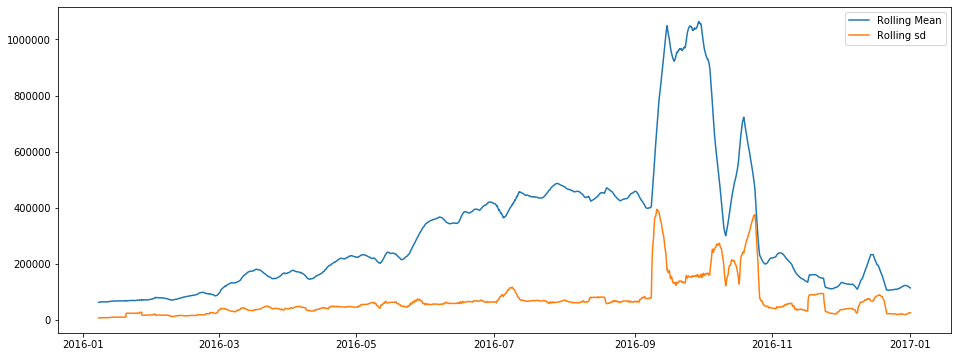

In [195]:
plt.figure(figsize=(16,6))
# 168時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=168,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=168,center=False).std(),label='Rolling sd');
plt.legend();

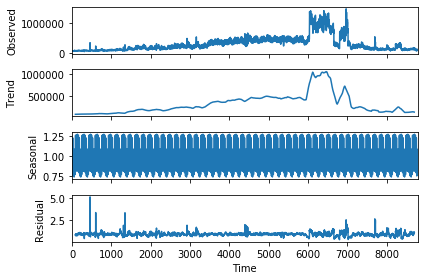

In [196]:
# multiplicative
# 168時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=168,model="multiplicative")
fig = res.plot()

## 蒸気

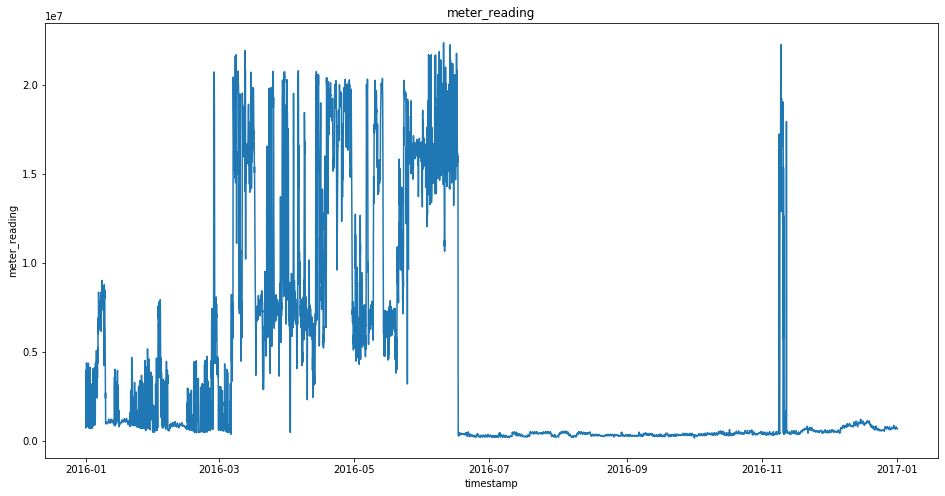

In [197]:
# ある時間の全ての建物、蒸気のmeter_readingの和
ts=train_df[train_df['meter']==2].groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

### 12時間おき

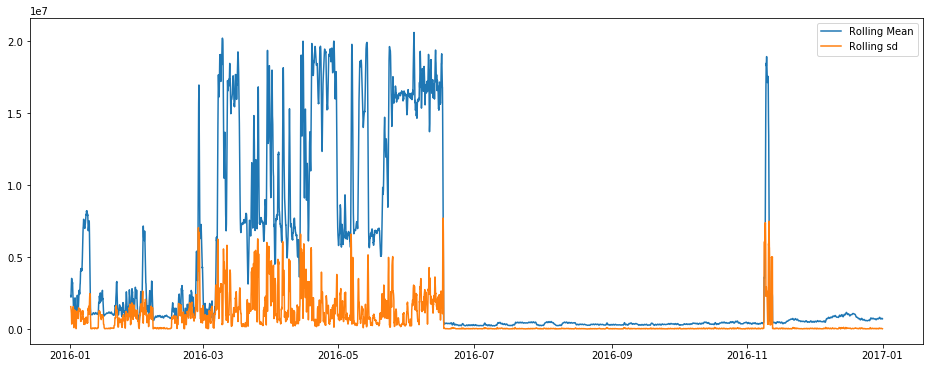

In [198]:
plt.figure(figsize=(16,6))
# 12時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

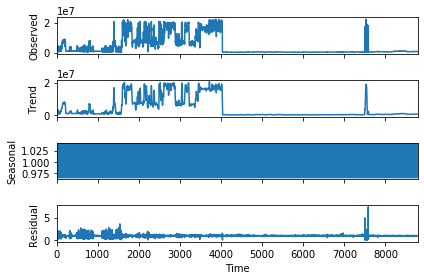

In [199]:
# multiplicative
# 12時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

### 1日おき

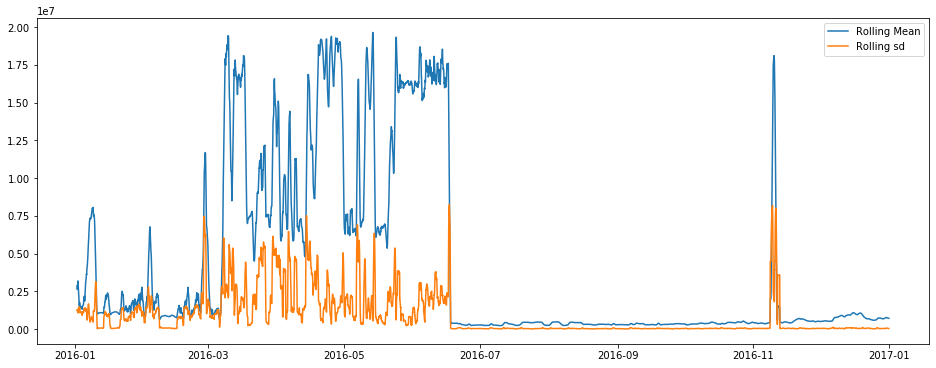

In [200]:
plt.figure(figsize=(16,6))
# 24時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=24,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=24,center=False).std(),label='Rolling sd');
plt.legend();

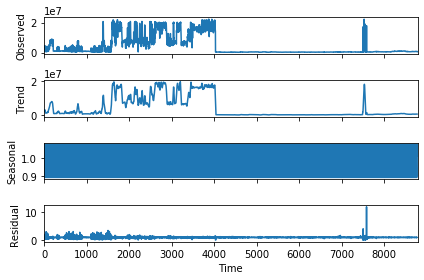

In [201]:
# multiplicative
# 24時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=24,model="multiplicative")
fig = res.plot()

### 7日おき

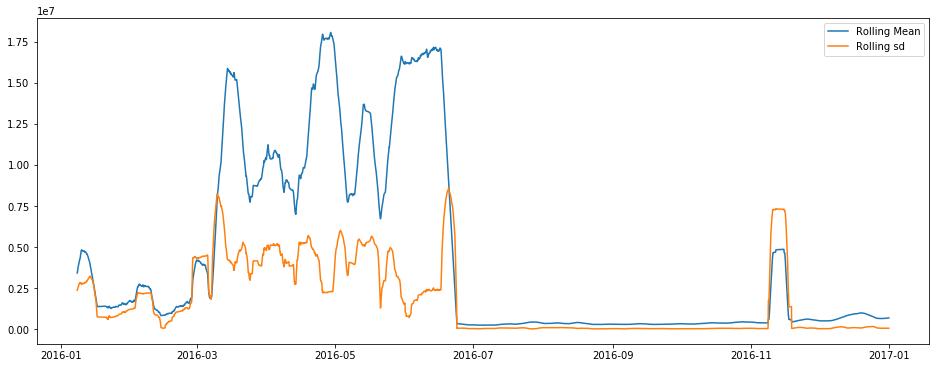

In [202]:
plt.figure(figsize=(16,6))
# 168時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=168,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=168,center=False).std(),label='Rolling sd');
plt.legend();

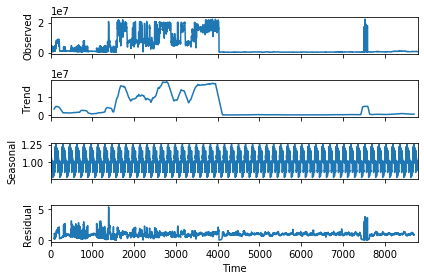

In [203]:
# multiplicative
# 168時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=168,model="multiplicative")
fig = res.plot()

## 温水

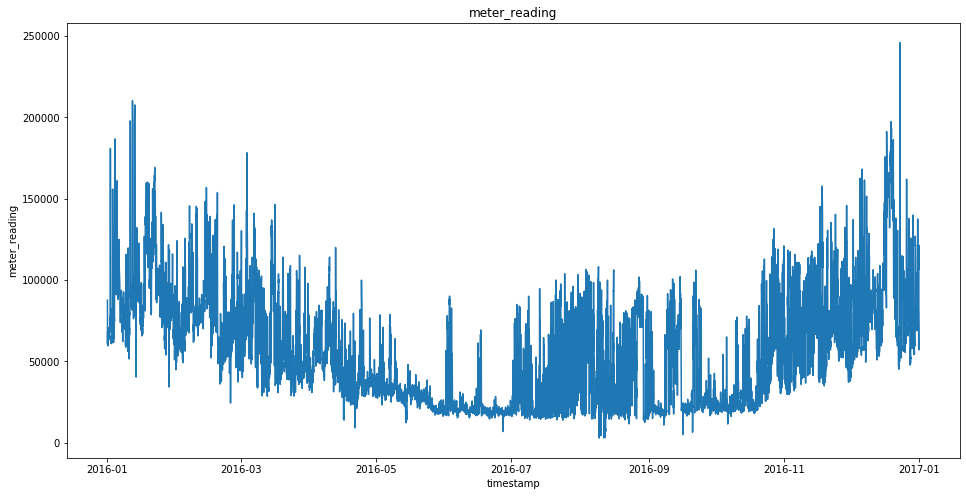

In [204]:
# ある時間の全ての建物、温水のmeter_readingの和
ts=train_df[train_df['meter']==3].groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

### 12時間おき

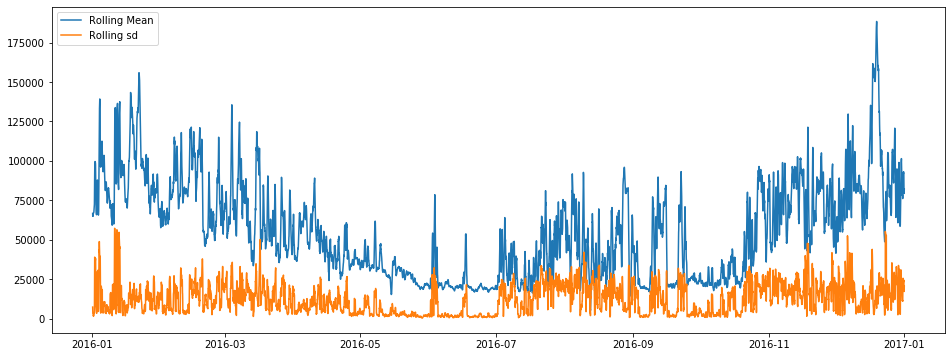

In [205]:
plt.figure(figsize=(16,6))
# 12時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

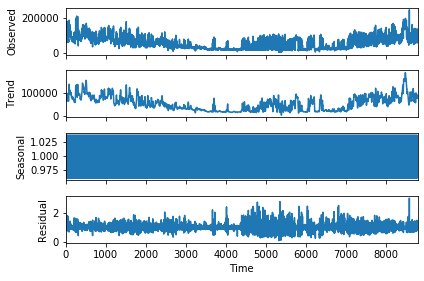

In [206]:
# multiplicative
# 12時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

### 1日おき

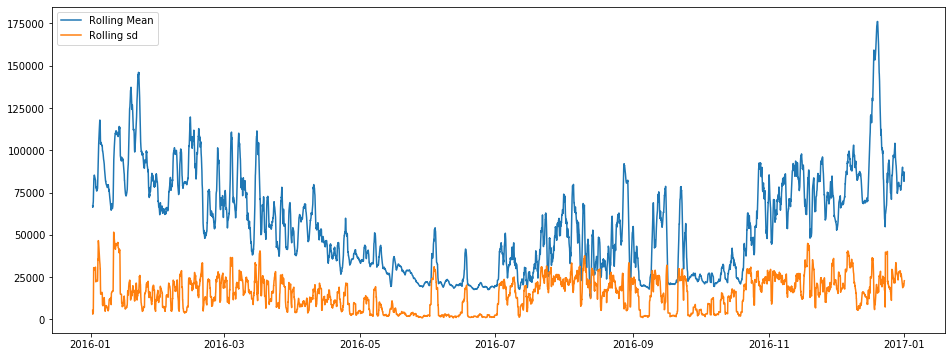

In [207]:
plt.figure(figsize=(16,6))
# 24時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=24,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=24,center=False).std(),label='Rolling sd');
plt.legend();

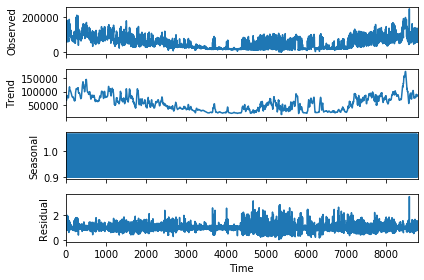

In [208]:
# multiplicative
# 24時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=24,model="multiplicative")
fig = res.plot()

### 7日おき

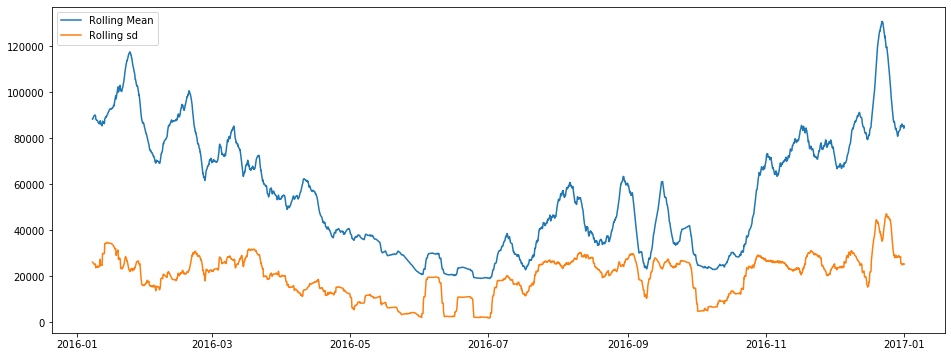

In [209]:
plt.figure(figsize=(16,6))
# 168時間分のmeter_readingの平均、標準偏差
plt.plot(ts.rolling(window=168,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=168,center=False).std(),label='Rolling sd');
plt.legend();

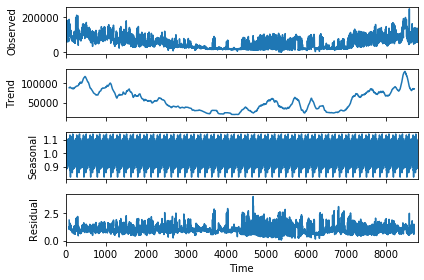

In [210]:
# multiplicative
# 168時間を周期として、観測データ・トレンド成分・季節成分・残差に分解
# 観測データ＝トレンド成分＋季節成分＋残差
res = sm.tsa.seasonal_decompose(ts.values,freq=168,model="multiplicative")
fig = res.plot()

# <a id='9'>9. Outlier Distribution</a>


<a href='#1'>Top</a>

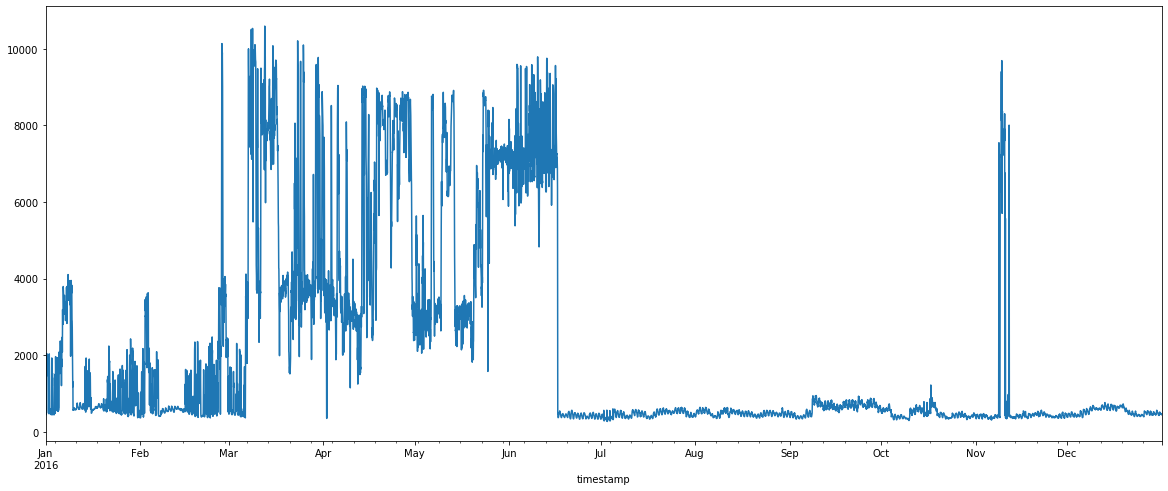

In [211]:
# 時間ごとのmeter_reading（の和の）平均
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

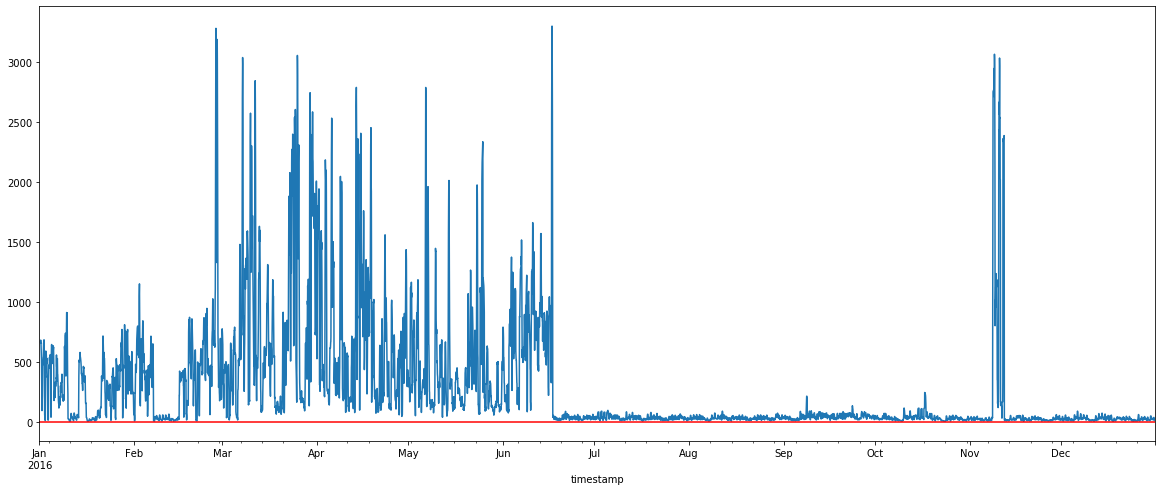

In [212]:
# 10時間ごとにresamplingした平均meter_readingの標準偏差
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
# baseline?
ax = plt.axhline(y=0.009, color='red')

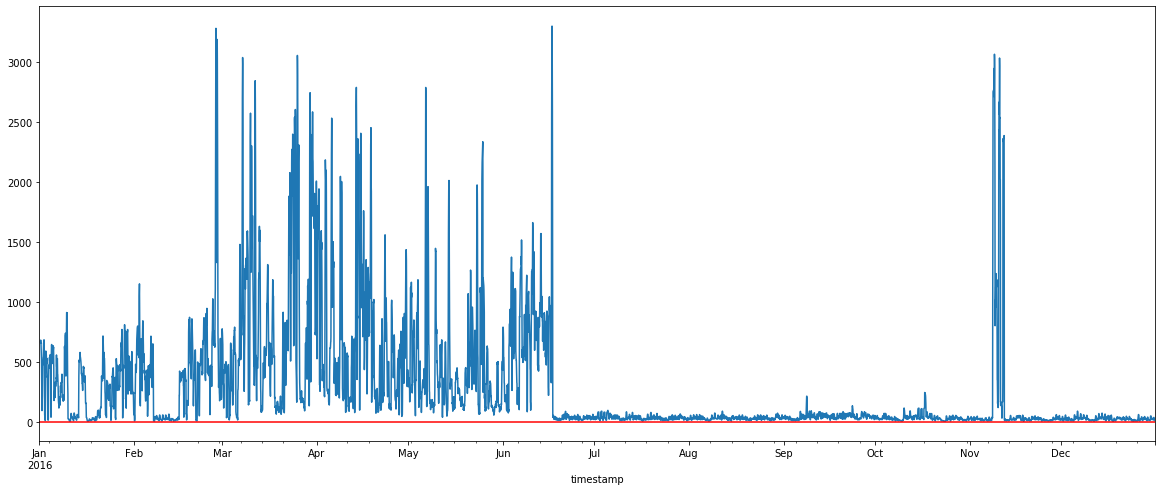

In [213]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green')
plt.axvspan(906, 1505, color='red')

## <a id='9-1'>9.1. Group data in a daily basis</a>


Look this, by [juanmah](https://www.kaggle.com/juanmah) : [AHRAE Outliers](https://www.kaggle.com/juanmah/ashrae-outliers/notebook) (Upvote this!) 

In [214]:
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train = train_df.copy()
# 日毎にgroup_by
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

meter_reading
date       building_id meter                      
2016-01-01 0           electricity        0.000000
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity        0.000000
...                                            ...
2016-12-31 1447        hotwater                NaN
           1448        electricity       79.974998
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN

[2121336 rows x 1 columns]

## <a id='9-2'>9.2. Aggregate the data for buildings</a>


In [215]:
# 各メーターで1日ごとに合計値、平均値、最大のbuilding_id、最大値を見る
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
# level_0...sum, mean, idxmax, max
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05


> ### Some plots

In [216]:
# 各meterの合計値
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

The sum, facetted for each energy aspect, shows some aberrant values.

## 1つの建物の影響が大きい

In [217]:
# 各メーターの最大値
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

Looking at the max value for each day, and for each energy aspect, shows that only a single building (for day and energy aspect) is causing the aberrant peaks

## <a id='9-3'>9.3. Identifying outliers</a>


In [218]:
# 各メーターの1日の最大値をとるbuilding_idを取得
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05,803
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05,1289
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07,1099
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05,1331
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05,803


In [219]:
daily_train_agg.tail()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
1459,2016-12-30,hotwater,2.077853e+06,14330.019531,"(2016-12-30, 1021, hotwater)",5.124206e+05,1021
1460,2016-12-31,electricity,5.066865e+06,3608.878418,"(2016-12-31, 799, electricity)",1.343883e+05,799
1461,2016-12-31,chilledwater,2.102037e+06,4246.539551,"(2016-12-31, 50, chilledwater)",8.256347e+04,50
1462,2016-12-31,steam,1.718295e+07,53033.812500,"(2016-12-31, 1168, steam)",1.324875e+06,1168
1463,2016-12-31,hotwater,2.086813e+06,14391.812500,"(2016-12-31, 1021, hotwater)",4.132599e+05,1021


In [220]:
def show_building(building, energy_aspects=None):
    fig = px.line(daily_train.loc[(slice(None), building, slice(None)), :].reset_index(),
                  x='date',
                  y='meter_reading',
                  color='meter',
                  render_mode='svg')
    if energy_aspects:
        if 'electricity' not in energy_aspects:
            fig['data'][0].visible = 'legendonly'
        if 'chilledwater' not in energy_aspects:
            fig['data'][1].visible = 'legendonly'
        if 'steam' not in energy_aspects:
            fig['data'][2].visible = 'legendonly'
        if 'hotwater' not in energy_aspects:
            fig['data'][3].visible = 'legendonly'
    fig.update_layout(title='Building ID: {}'.format(building))        
    fig.show()
    display(building_metadata[building_metadata['building_id']==building])

> ### Electricity

## 1日で最大の電力消費となった建物とその日数

In [221]:
print('Number of days that a building has the maximum electricity consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())

Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64


The max values of electricity are caused by only 6 buildings.

In [222]:
daily_train_electricity = daily_train_agg[daily_train_agg['meter']=='electricity'].copy()
daily_train_electricity['building_id_max'] = pd.Categorical(daily_train_electricity['building_id_max'])
fig_daily_electricity = px.scatter(daily_train_electricity,
                                   x='date',
                                   y='meter_reading-max',
                                   color='building_id_max',
                                   render_mode='svg')
fig_daily_electricity.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_electricity.show()

> ### Chilledwater

In [223]:
print('Number of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())

Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64


The max values of electricity are caused by only 10 buildings.

In [224]:
daily_train_chilledwater = daily_train_agg[daily_train_agg['meter']=='chilledwater'].copy()
daily_train_chilledwater['building_id_max'] = pd.Categorical(daily_train_chilledwater['building_id_max'])
fig_daily_chilledwater = px.scatter(daily_train_chilledwater,
                                    x='date',
                                    y='meter_reading-max',  
                                    color='building_id_max', 
                                    render_mode='svg')
fig_daily_chilledwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_chilledwater.show()

> ### Steam

In [225]:
print('Number of days that a building has the maximum steam consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())

Number of days that a building has the maximum steam consumption of all the buildings:

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64


The max values of electricity are caused by only 4 buildings.

In [226]:
daily_train_steam = daily_train_agg[daily_train_agg['meter']=='steam'].copy()
daily_train_steam['building_id_max'] = pd.Categorical(daily_train_steam['building_id_max'])
fig_daily_steam = px.scatter(daily_train_steam,
                             x='date',
                             y='meter_reading-max',
                             color='building_id_max',
                             render_mode='svg')
fig_daily_steam.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_steam.show()

> ### Hotwater

In [227]:
print('Number of days that a building has the maximum hotwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].value_counts())

Number of days that a building has the maximum hotwater consumption of all the buildings:

1021    229
1331    120
1317      7
794       7
1323      1
1252      1
1232      1
Name: building_id_max, dtype: int64


The max values of electricity are caused by only 7 buildings. Practically, two of them

In [228]:
daily_train_hotwater = daily_train_agg[daily_train_agg['meter']=='hotwater'].copy()
daily_train_hotwater['building_id_max'] = pd.Categorical(daily_train_hotwater['building_id_max'])
fig_daily_hotwater = px.scatter(daily_train_hotwater,
                                x='date',
                                y='meter_reading-max',
                                color='building_id_max',
                                render_mode='svg')
fig_daily_hotwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_hotwater.show()


    Taking only the buildings that consume more than the others, could be seen that there are a lot of measure scale errors.
    The error could be:

    The meter is not configured correctly. E.g., a bad voltage or current primary to secondary ratio.
    The software has not the units configured correctly. E.g., MJ/kg for steam.
    The software has not the decimal digits configured correctly.
    Using a power variable instead of an energy one.
    The measure could be done with an unique meter, or the sum of several of them.

    Some changes over time, values go to zero or the scale is changed, indicates that some buildings have more than one meter. One error in one meter and the overall measure is garbage.

    This notebook has only analised the outliers that influence the maximum consumption in a daily basis. This is only the tip of the iceberg. A sound analysis should be done to detect and correct these outliers.

    A solution to avoid scale errors is to normalize the values from 0 to 1, for each building and for each energy aspect.

# <a id='10'>10 Simple Feature Engineering and Modeling </a>


<a href='#1'>Top</a>

In [229]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [254]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [231]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

## 築何年目か

In [246]:
building_meta_df['age'] = building_meta_df['year_built'].max() - building_meta_df['year_built'] + 1
building_meta_df['age'] = building_meta_df['year_built'].max() - building_meta_df['year_built'] + 1

In [232]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [235]:
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

/Users/numatakouhei/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [236]:
train_df = train_df.query('not (building_id <= 104 & meter == "electricity" & timestamp <= "2016-05-20")')

In [237]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

In [247]:
# train
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
#train_df['year_built'] = train_df['year_built']-1900
#train_df['square_feet'] = np.log(train_df['square_feet'])

# test
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
#test_df['year_built'] = test_df['year_built']-1900
#test_df['square_feet'] = np.log(test_df['square_feet'])

In [238]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0
1,0,0,1,7062,1,8763,52,3,0
2,0,0,1,2354,1,66,44,591,5
3,0,0,4,3642,6,37,158,153,4
4,0,0,0,4230,2,1317,73,105,0
5,0,0,2,6030,2,8755,8755,295,3
6,0,0,10,2992,10,0,175,779,39
7,0,0,0,8614,23,7883,8,0,0
8,0,0,3,3830,3,1,85,250,0


In [239]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [240]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


In [241]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
            'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [242]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)
add_lag_feature(weather_train_df, window=168)

In [243]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,air_temperature_max_lag3,air_temperature_min_lag3,air_temperature_std_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,cloud_coverage_min_lag3,cloud_coverage_std_lag3,dew_temperature_mean_lag3,dew_temperature_max_lag3,dew_temperature_min_lag3,dew_temperature_std_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_std_lag3,sea_level_pressure_mean_lag3,sea_level_pressure_max_lag3,sea_level_pressure_min_lag3,sea_level_pressure_std_lag3,wind_direction_mean_lag3,wind_direction_max_lag3,wind_direction_min_lag3,wind_direction_std_lag3,wind_speed_mean_lag3,wind_speed_max_lag3,wind_speed_min_lag3,wind_speed_std_lag3,air_temperature_mean_lag72,air_temperature_max_lag72,air_temperature_min_lag72,air_temperature_std_lag72,cloud_coverage_mean_lag72,cloud_coverage_max_lag72,cloud_coverage_min_lag72,cloud_coverage_std_lag72,dew_temperature_mean_lag72,dew_temperature_max_lag72,dew_temperature_min_lag72,dew_temperature_std_lag72,precip_depth_1_hr_mean_lag72,precip_depth_1_hr_max_lag72,precip_depth_1_hr_min_lag72,precip_depth_1_hr_std_lag72,sea_level_pressure_mean_lag72,sea_level_pressure_max_lag72,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72,air_temperature_mean_lag168,air_temperature_max_lag168,air_temperature_min_lag168,air_temperature_std_lag168,cloud_coverage_mean_lag168,cloud_coverage_max_lag168,cloud_coverage_min_lag168,cloud_coverage_std_lag168,dew_temperature_mean_lag168,dew_temperature_max_lag168,dew_temperature_min_lag168,dew_temperature_std_lag168,precip_depth_1_hr_mean_lag168,precip_depth_1_hr_max_lag168,precip_depth_1_hr_min_lag168,precip_depth_1_hr_std_lag168,sea_level_pressure_mean_lag168,sea_level_pressure_max_lag168,sea_level_pressure_min_lag168,sea_level_pressure_std_lag168,wind_direction_mean_lag168,wind_direction_max_lag168,wind_direction_min_lag168,wind_direction_std_lag168,wind_speed_mean_lag168,wind_speed_max_lag168,wind_speed_min_lag168,wind_speed_std_lag168
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,-1.0,1019.5,0.0,0.000000,25.000000,25.000000,25.000000,NaN,6.000000,6.0,6.0,NaN,20.000000,20.00000,20.00000,NaN,-1.000000,-1.0,-1.0,NaN,1019.5,1019.5,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN,25.000000,25.0,25.000000,NaN,6.000000,6.0,6.0,NaN,20.000000,20.00000,20.0,NaN,-1.000000,-1.0,-1.0,NaN,1019.5,1019.5,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN,25.000000,25.0,25.000000,NaN,6.000000,6.0,6.0,NaN,20.000000,20.00000,20.0,NaN,-1.000000,-1.0,-1.0,NaN,1019.5,1019.5,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.406250,4.0,21.09375,-1.0,1020.0,70.0,1.500000,24.703125,25.000000,24.406250,0.419922,5.000000,6.0,4.0,1.414062,20.546875,21.09375,20.00000,0.773438,-1.000000,-1.0,-1.0,0.000000,1020.0,1020.0,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547,24.703125,25.0,24.406250,0.419922,5.000000,6.0,4.0,1.414062,20.546875,21.09375,20.0,0.773438,-1.000000,-1.0,-1.0,0.000000,1020.0,1020.0,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547,24.703125,25.0,24.406250,0.419922,5.000000,6.0,4.0,1.414062,20.546875,21.09375,20.0,0.773438,-1.000000,-1.0,-1.0,0.000000,1020.0,1020.0,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,24.062500,25.000000,22.796875,1.139648,4.000000,6.0,2.0,2.000000,20.734375,21.09375,20.00000,0.631348,-0.666504,0.0,-1.0,0.577148,1020.0,1020.0,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211,24.062500,25.0,22.796875,1.139648,4.000000,6.0,2.0,2.000000,20.734375,21.09375,20.

In [244]:
primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)}
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


In [250]:
category_cols = ['building_id', 'site_id', 'primary_use']
feature_cols = ['square_feet', 'year_built', 'age'] + ['month_datetime',
                                                       'weekofyear_datetime', 'dayofyear_datetime',
                                                       'hour_datetime', 'day_week', 'day_month_datetime',
                                                       'week_month_datetime', 'week_month_datetime', 
                                                       'building_median'] + ['air_temperature', 
                                                                             'precip_depth_1_hr', 
                                                                             'sea_level_pressure', 'wind_direction', 
                                                                             'wind_speed', 
                                                                             'air_temperature_mean_lag168',
                                                                             'air_temperature_max_lag168', 
                                                                             'air_temperature_min_lag168',
                                                                             'air_temperature_std_lag168', 
                                                                             'cloud_coverage_mean_lag168',
                                                                             'dew_temperature_mean_lag168', 
                                                                             'precip_depth_1_hr_mean_lag168',
                                                                             'sea_level_pressure_mean_lag168',
                                                                             'wind_direction_mean_lag168',
                                                                             'wind_speed_mean_lag168', 
                                                                             'air_temperature_mean_lag72',
                                                                             'air_temperature_max_lag72', 
                                                                             'air_temperature_min_lag72',
                                                                             'air_temperature_std_lag72', 
                                                                             'cloud_coverage_mean_lag72',
                                                                             'dew_temperature_mean_lag72', 
                                                                             'precip_depth_1_hr_mean_lag72',
                                                                             'sea_level_pressure_mean_lag72', 
                                                                             'wind_direction_mean_lag72',
                                                                             'wind_speed_mean_lag72', 
                                                                             'air_temperature_mean_lag3',
                                                                             'air_temperature_max_lag3',
                                                                             'air_temperature_min_lag3', 
                                                                             'cloud_coverage_mean_lag3',
                                                                             'dew_temperature_mean_lag3',
                                                                             'precip_depth_1_hr_mean_lag3', 
                                                                             'sea_level_pressure_mean_lag3',
                                                                             'wind_direction_mean_lag3', 
                                                                             'wind_speed_mean_lag3']

## <a id='10-1'>10.1 Building DF merge through concat  </a>




> - Convert timestamp 
> - Convert Strings to category


In [257]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    
    target_train_df.to_pickle('target_train_df.pkl')
    del target_train_df
    return X_train, y_train

In [253]:
def fit_lgbm(train, val, devices=(-1, ), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
             'objective': 'regression',
             'learning_rate': lr,
             'boosting': 'gbdt',
             'bagging_fraction': bf,
             'feature_fraction': 0.9,
             'metric': metric
             }
    device = devices[0]
    if device == -1:
        pass
    else:
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})
        
    params['seed'] = seed
    
    early_stop = 100
    verbose_eval = 100
    
    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params, 
                     train_set=d_train,
                     num_boost_round=num_rounds,
                     valid_sets=watchlist,
                     verbose_eval=verbose_eval,
                     early_stopping_rounds=early_stop)
    
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
          'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [255]:
folds = 5
seed = 42
kf = TimeSeriesSplit(n_splits=folds)

## Train model by each meter type

target_meter electricity (11714696, 49)
cat_features [46, 47, 48]
Train 1952451 Valid 1952449
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.138934	valid_1's l2: 0.36022
Early stopping, best iteration is:
[50]	training's l2: 0.237282	valid_1's l2: 0.304776
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.23728232149072812)]), 'valid_1': OrderedDict([('l2', 0.3047761801612654)])})
Train 3904900 Valid 1952449
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.160332	valid_1's l2: 0.500169
[200]	training's l2: 0.107148	valid_1's l2: 0.491309
[300]	training's l2: 0.0893217	valid_1's l2: 0.48788
[400]	training's l2: 0.0788962	valid_1's l2: 0.486355
[500]	training's l2: 0.0719308	valid_1's l2: 0.485937
Early stopping, best iteration is:
[443]	training's l2: 0.0757382	valid_1's l2: 0.484632
best_score defaultdict(<class 'collections.OrderedDict'>, {'t

10

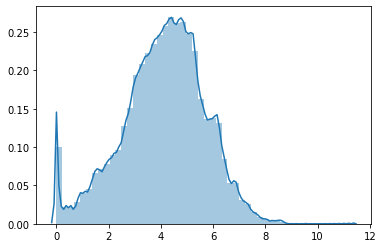

In [259]:
target_meter = 'electricity'
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx, :], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx, :], y_train[valid_idx]
    
    print('Train', len(train_idx), 'Valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data,
                                        cat_features=category_cols, num_rounds=1500, 
                                       lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    
sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter chilledwater (4182440, 49)
cat_features [46, 47, 48]
Train 697075 Valid 697073
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.581529	valid_1's l2: 3.11808
Early stopping, best iteration is:
[52]	training's l2: 0.816367	valid_1's l2: 3.04981
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.8163666699202348)]), 'valid_1': OrderedDict([('l2', 3.049808422938231)])})
Train 1394148 Valid 697073
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.796852	valid_1's l2: 2.53223
[200]	training's l2: 0.619252	valid_1's l2: 2.47795
[300]	training's l2: 0.538419	valid_1's l2: 2.45827
Early stopping, best iteration is:
[291]	training's l2: 0.544216	valid_1's l2: 2.45269
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.5442160766371397)]), 'valid_1': OrderedDict([('l2', 2.4526885379215337)])})
Train 20912

10

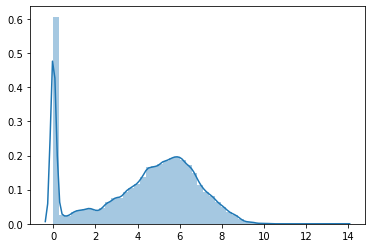

In [260]:
target_meter = 'chilledwater'
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('Train', len(train_idx), 'Valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1500,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter steam (2708713, 49)
cat_features [46, 47, 48]
train 451453 valid 451452
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.656452	valid_1's l2: 2.81188
[200]	training's l2: 0.495629	valid_1's l2: 2.83117
Early stopping, best iteration is:
[109]	training's l2: 0.629318	valid_1's l2: 2.80325
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.6293176173380349)]), 'valid_1': OrderedDict([('l2', 2.8032512128467184)])})
train 902905 valid 451452
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.907257	valid_1's l2: 3.19412
[200]	training's l2: 0.744666	valid_1's l2: 3.00253
[300]	training's l2: 0.672356	valid_1's l2: 2.95087
[400]	training's l2: 0.625694	valid_1's l2: 2.9289
[500]	training's l2: 0.59369	valid_1's l2: 2.88773
[600]	training's l2: 0.566298	valid_1's l2: 2.86707
[700]	training's l2: 0.544067	valid_1's l2: 2.85735
[800]	training'

10

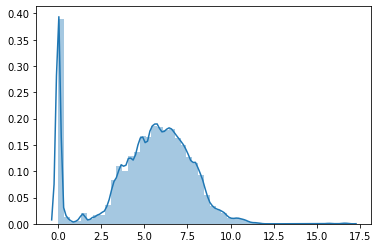

In [261]:
target_meter = 'steam'
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1500, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter hotwater (1264037, 49)
cat_features [46, 47, 48]
train 210677 valid 210672
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.09049	valid_1's l2: 3.12388
[200]	training's l2: 0.858614	valid_1's l2: 2.88864
[300]	training's l2: 0.761426	valid_1's l2: 2.82433
[400]	training's l2: 0.707803	valid_1's l2: 2.81711
[500]	training's l2: 0.6735	valid_1's l2: 2.80409
[600]	training's l2: 0.644728	valid_1's l2: 2.79885
[700]	training's l2: 0.622854	valid_1's l2: 2.78968
[800]	training's l2: 0.603771	valid_1's l2: 2.78578
[900]	training's l2: 0.586092	valid_1's l2: 2.7803
[1000]	training's l2: 0.567996	valid_1's l2: 2.77311
[1100]	training's l2: 0.552883	valid_1's l2: 2.76926
[1200]	training's l2: 0.538586	valid_1's l2: 2.76787
[1300]	training's l2: 0.526346	valid_1's l2: 2.76769
Early stopping, best iteration is:
[1252]	training's l2: 0.531809	valid_1's l2: 2.76337
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': O

10

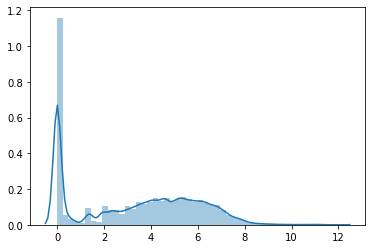

In [262]:
target_meter = 'hotwater'
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1500,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()

sns.distplot(y_train)
del X_train, y_train
gc.collect()

# Prediction

In [264]:
print('preprocessing building...')
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)
add_lag_feature(weather_test_df, window=168)

print('reduce mem usage...')
reduce_mem_usage(test_df)
reduce_mem_usage(weather_test_df)

gc.collect()

preprocessing building...
preprocessing weather...
reduce mem usage...
Mem. usage decreased to 1312.28 Mb (0.0% reduction)
Mem. usage decreased to 50.50 Mb (0.0% reduction)


7656

In [265]:
reduce_mem_usage(sample_submission)

Mem. usage decreased to 198.83 Mb (68.7% reduction)


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [267]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [268]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

  0%|          | 0/25 [00:00<?, ?it/s]

iterations 25
predicting 0-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 25/25 [09:16<00:00, 22.26s/it]


CPU times: user 2h 13min 27s, sys: 1min 56s, total: 2h 15min 24s
Wall time: 19min 44s


10

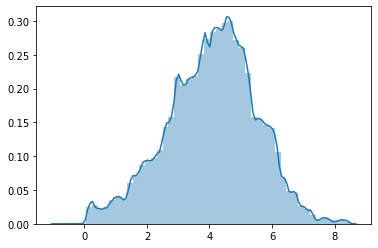

In [277]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

  0%|          | 0/9 [00:00<?, ?it/s]

iterations 9
predicting 0-th model


  0%|          | 0/9 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/9 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/9 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/9 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 9/9 [00:56<00:00,  6.33s/it]


CPU times: user 28min 22s, sys: 27.7 s, total: 28min 50s
Wall time: 4min 11s


10

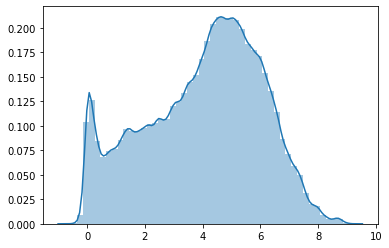

In [278]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

  0%|          | 0/6 [00:00<?, ?it/s]

iterations 6
predicting 0-th model


  0%|          | 0/6 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/6 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/6 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/6 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 6/6 [00:34<00:00,  5.75s/it]


CPU times: user 26min 15s, sys: 17 s, total: 26min 32s
Wall time: 3min 42s


14

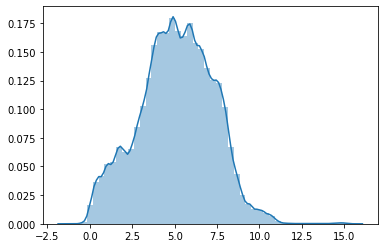

In [279]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

iterations 3
predicting 0-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


10

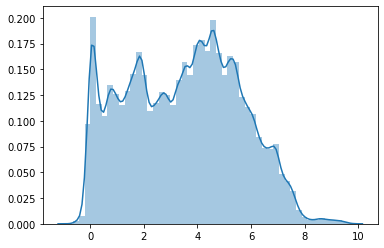

In [280]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [281]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [283]:
import datetime
today = str(datetime.date.today())
sample_submission.to_csv(f'submission_{today}_1.csv', index=False, float_format='%.4f')


## <a id='10-2'>10.2 Weather DF merge over concat  </a>



# <a id='11'>11. ASHRAE - Data minification</a>


<a href='#1'>Top</a>

> Use can use train_df.pkl, test_df.pkl for FE, FS for your baseline_predict

In [121]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
   
del train_df, test_df
gc.collect()

104558

In [122]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')


# <a id='12'>12. Some Features</a>


<a href='#1'>Top</a>

Kaggle competitions are won by feature engineering

> ### Stanford Professor Andrew Ng accurately said, “…applied machine learning is basically feature engineering.”
See this: https://blog.featurelabs.com/secret-to-data-science-success/


# <a id='13'>13. Encoding Variables</a>



<a href='#1'>Top</a>


<p><font size="3" color="green" style="Comic Sans MS;">
Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](Encoding Variables). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

You can see [this](https://www.kaggle.com/alexisbcook/categorical-variables):

</font></p>



## Label Encoding:
Label encoding assigns each unique value to a different integer.

![](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect label encoding to work well with ordinal variables.

In [124]:
le = LabelEncoder()
# train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

# test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)



# <a id='14'>14. Handling missing values</a>




<a href='#1'>Top</a>

### Types of missing data
> It is helpful to create and test hypotheses around why the data would be potentially missing, it is because the sensor recording the data disconnected from the server, the person feeding paper forms into the spreadsheet missed it or is the data missing for a particular category of rows.

To streamline this though process it is useful to know the 3 categories in which missing data can be classified into:

* Missing Completely at Random (**MCAR**)
* Missing at Random (**MAR**)
* Missing Not at Random (**MNAR**)

Time series imputation
1. Non-time-series specific method
1. mean imputation
1. median imputation
1. mode imputation
1. calcucate the appropriate measure and replace NAs with the values.
#### appropriate for stationary time series, for example, white noise data

1. Random sample imputation
replace missing values with observations randomly selected from the remaining (either of it or just some section of it)
#### It is not likely to work well unless the random select is carefully chosen.


Time-Series specific method
* Last observation carried forward (LOCF)
* Next observation carried backward (NOCB)
* Linear interpolation
* Spline interpolation 

#### These methods rely on the assumption that adjacent observations are similar to one another. These methods do not work well when this assumption is not valid, especially when the presence of strong seasonality.

This kernel it's helpfull for this: https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners


Manually dealing with missing values will often improve model performance.

Our approach we input fill NaN = -999 just for the 4 features with most missing values

In [125]:

train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 


> ### Some datetime features

> - Drop collumns

> #### Separating a target value, also log transform it.

In [127]:
from tqdm import tqdm

In [128]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed","timestamp"]
target = np.log1p(train_df["meter_reading"])  
# del train["meter_reading"]
# train_df = train_df.drop(drop_cols, axis=1)

In [129]:
import lightgbm as lgb
from sklearn.model_selection import KFold
# lightbgm
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'learning_rate': 0.9,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'alpha': 0.1,
    'lambda': 0.1
}

In [133]:
%%time
folds = 5
seed = 41 #666
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for i, (train_index, val_index) in enumerate(kf.split(train_df)):　# timesplitに
    print(f'Training on fold {i + 1}')
    
    train_X = train_df.iloc[train_index]
    val_X = train_df.iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_eval = lgb.Dataset(val_X, val_y)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=10, #300,
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds= 10,#100,
                    verbose_eval=10) #100)
    models.append(gbm)

SyntaxError: invalid character in identifier (<unknown>, line 6)

In [77]:
del train, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

0

<a href='#1'>Top</a>

> ## See this: [⚡🔌ASHRAE : Lgbm Simple FE](https://www.kaggle.com/caesarlupum/ashrae-lgbm-simple-fe) 

  > ⚡ Please, you can use parts of this notebook in your own scripts or kernels, no problem, but please give credit (for example link back to this, see this...)

# <a id='18'>ASHRAE Energy prediction - summary</a>


<a href='#1'>Top</a>

<html>
<body>

<p><font size="4" color="Green"> ASHRAE Standard 90.1 2010, Part III -- HVAC Provisions</font></p>

</body>
</html>


In [78]:
HTML('<iframe width="829" height="622" src="https://www.youtube.com/embed/ABAR8TIwce4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

<html>
<body>

<p><font size="4" color="Green"> ASHRAE -- What It Is and Where It Is Going</font></p>

</body>
</html>


In [79]:
HTML('<iframe width="847" height="622" src="https://www.youtube.com/embed/wjRJsbj3X00" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

> ## General findings

Published Articles on Energy Consumtion Prediction

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113080#latest-665324

Geo location:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115040#latest-667889
https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-667385
https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-667385

Outliers:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113254

Holidays:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113286

Metric:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064#latest-663076




<html>
<body>

<p><font size="5" color="Blue">If you like my kernel please consider upvoting it</font></p>
<p><font size="4" color="Green">Don't hesitate to give your suggestions in the comment section</font></p>

</body>
</html>


# <a id='17'>17. Final</a>